# Profile table
In this exploration we're going to do the bulk of the work preparing a data set to use as additional data for a hybrid recommender.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

print('Pandas version    : {}'.format(pd.__version__))
print('Numpy version    : {}'.format(np.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))
print('Seaborn version   : {}'.format(sns.__version__))

path = '../data/'

Pandas version    : 0.20.1
Numpy version    : 1.12.1
Matplotlib version: 2.0.2
Seaborn version   : 0.7.1


In [2]:
profiles = pd.read_csv(path + 'surgeapp_profiles.raw.csv')

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', r'call to matplotlib.use() has no effect')
import pandas_profiling as pp
pp.ProfileReport(profiles)

/Users/davenovelli/miniconda3/envs/strvworkshop/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/Users/davenovelli/miniconda3/envs/strvworkshop/lib/python3.5/site-packages/pandas_profiling/base.py:223: RuntimeWarning: divide by zero encountered in long_scalars
  'p_unique': distinct_count / count}


Number of variables,46
Number of observations,6550
Total Missing (%),38.2%
Total size in memory,2.3 MiB
Average record size in memory,368.0 B
Numeric,6
Categorical,33
Date,0
Text (Unique),2
Rejected,5
Distinct count,2731


## Based on an initial review, there are some fields we can start by getting rid of

In [3]:
# Any values that only have a single value, then they're useless and get rid of them (promoted, show_distance_enabled,
# show_age_enabled, birthday_enabled, score, ...)
del profiles['birthday_enabled']
del profiles['cloud_vision_review']
del profiles['handkerchief_code_keys']
del profiles['show_age_enabled']
del profiles['show_distance_enabled']

# Any variables that are totally (or nearly) unique and don't have any opportunity to extract new features out of, for
# example numerical IDs, tokens, names, flags that are almost entirely a single value
del profiles['instagram_name']
del profiles['instagram_id']
del profiles['instagram_access_token']
del profiles['promoted']
del profiles['private_mode']
del profiles['custom_location']
del profiles['transgender']
del profiles['body_type']
del profiles['interests_enabled']
del profiles['hide_distance']
del profiles['hide_age']
del profiles['couple']

# Name seems like a very dubious indicator of preference and there's way too many possible values. We'll drop this
del profiles['name']

# Location impacts who sees who, but unlikely to impact who likes who.
del profiles['location']

# Hidden seems useful for filtering, but not relevant to interest
del profiles['hidden']

# Status - ignore - this is useful for filtering but I think we probably don't care about this
del profiles['status']

# GMT offset - people travel, and we don't want their implied preference for people in their own timezone to affect
# their recommendations when travelling
del profiles['gmt_offset']

## Begin building new features from the raw data

### Birthday -> Age

In [4]:
# Birthday - convert to age
from datetime import date

def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

# Needs to be a datetime type
profiles['birthday'] = profiles.birthday.astype('datetime64[ns]')
profiles['age'] = profiles.birthday.map(calculate_age)
np.sort(profiles.age.unique())

array([ 15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  74,  78,  85, 100, 101, 102, 108,
       116, 117, 124, 223, 241])

In [5]:
# I don't think anyone was born 200+ years ago, but maybe? Let's convert birthday into an age and fill in
# missing age values with the mean
profiles.loc[(profiles.age < 14) | (profiles.age > 85), 'age'] = \
    int(profiles[(profiles.age > 13) | (profiles.age < 86)].age.mean())
np.sort(profiles.age.unique())

array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 74, 78, 85])

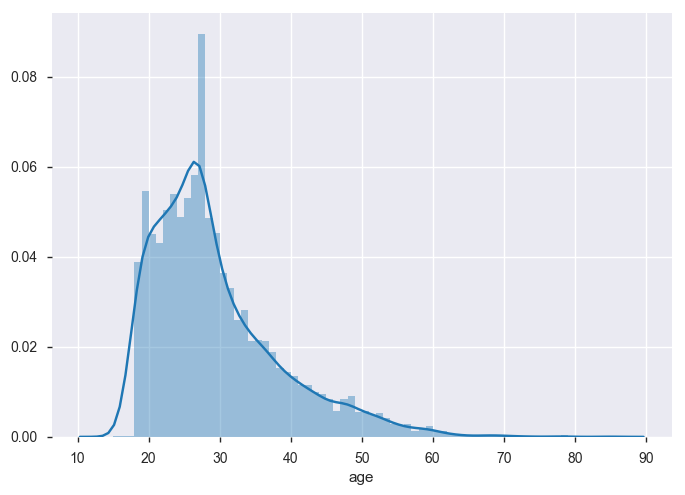

In [6]:
sns.distplot(profiles.age, bins=profiles.age.max()-profiles.age.min());

### Weight (in g) -> Weight (kg)

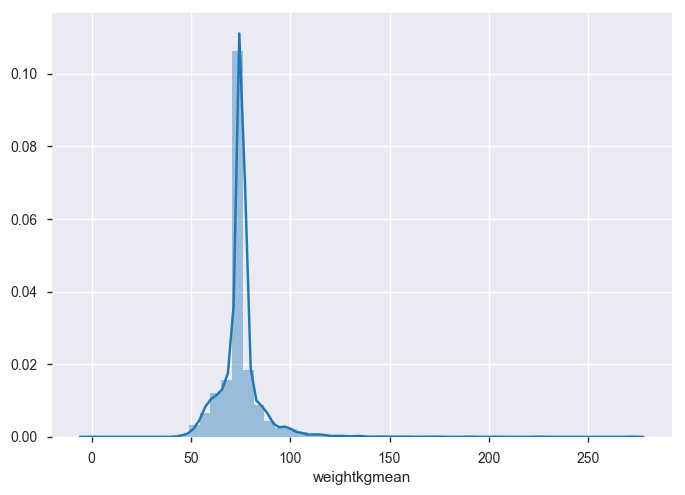

In [7]:
# Weight is currently being measured in fractional grams. Round to nearest kg
profiles['weightkg'] = profiles.weight
profiles.loc[pd.notnull(profiles.weight), 'weightkg'] = \
    (profiles[pd.notnull(profiles.weight)].weight / 1000).astype(int)

# Replacing weight with the mean is the easy approach. It's also not good because there are so many missing values...
profiles['weightkgmean'] = profiles.weightkg
profiles.loc[pd.isnull(profiles.weightkg), 'weightkgmean'] = int(profiles.weightkg.mean())
sns.distplot(profiles.weightkgmean);

To try to get more variation in our imputed values, we can try to generate a regression based on other fields that are present when weight is missing. Height and age are both relevant and should provide a more fine-grained imputation. Let's take a look at distributions of those parameters when weight is missing...

Number of records that have no weight but do have age: 3295


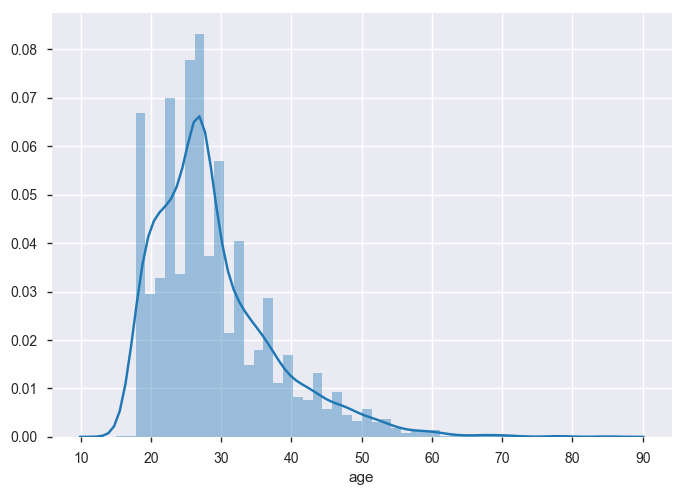

Number of records that have no weight but do have height: 471


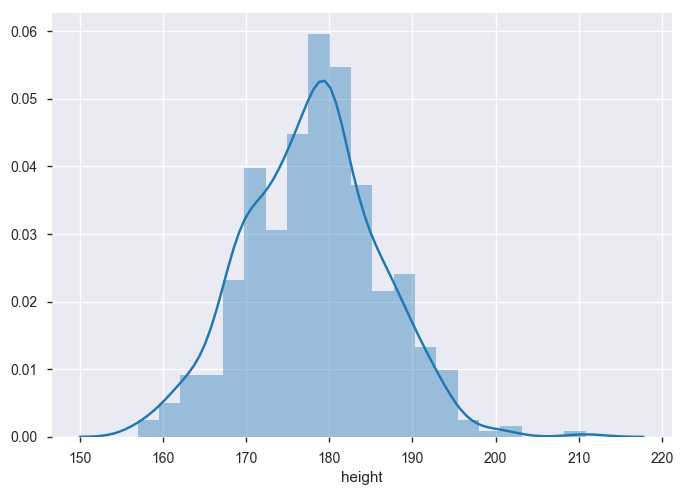

In [8]:
print("Number of records that have no weight but do have age: {}"
      .format(len(profiles[pd.isnull(profiles.weightkg) & pd.notnull(profiles.age)])))
sns.distplot(profiles[pd.isnull(profiles.weightkg)].age);
plt.show()

print("Number of records that have no weight but do have height: {}"
      .format(len(profiles[pd.isnull(profiles.weightkg) & pd.notnull(profiles.height)])))
sns.distplot(profiles[pd.isnull(profiles.weightkg)].height.dropna());

In [9]:
from sklearn.linear_model import LinearRegression
cols = ['weightkg', 'height', 'age']
wdf = profiles[cols].dropna()
X = wdf.iloc[:, 1:]
y = wdf.iloc[:, 0].to_frame()

lr = LinearRegression()
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Number of records that do not have a value for weightkg: 3295
Number of records that do not have a value for weightkg: 2824


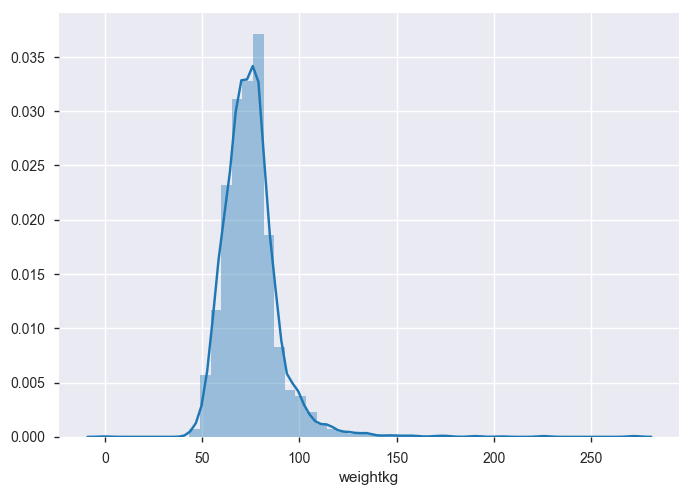

In [10]:
idx = pd.isnull(profiles.weightkg) & pd.notnull(profiles.height) & pd.notnull(profiles.age)
print("Number of records that do not have a value for weightkg: {}".format(len(profiles[pd.isnull(profiles.weightkg)])))
profiles.loc[idx, 'weightkg'] = lr.predict(profiles[cols][idx].values[:, 1::]).astype(int)
print("Number of records that do not have a value for weightkg: {}".format(len(profiles[pd.isnull(profiles.weightkg)])))
sns.distplot(profiles.weightkg.dropna());

So we updated ~450 records by using both age and height. These will be the most accurate imputations. However, many records don't have height either, so we'll do this again just using age which isn't nearly as strongly correlated as height...

Number of records that do not have a value for weightkg: 0


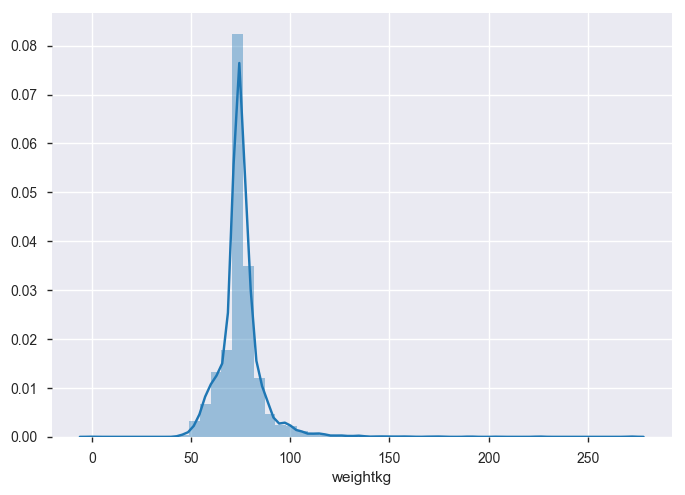

In [11]:
cols = ['weightkg', 'age']
wdf = profiles[cols].dropna()
X = wdf.iloc[:, 1].to_frame()
y = wdf.iloc[:, 0].to_frame()

lr = LinearRegression()
lr.fit(X, y)

idx = pd.isnull(profiles.weightkg) & pd.notnull(profiles.age)
profiles.loc[idx, 'weightkg'] = lr.predict(profiles[cols][idx].values[:, 1::]).astype(int)
print("Number of records that do not have a value for weightkg: {}".format(len(profiles[pd.isnull(profiles.weightkg)])))
sns.distplot(profiles.weightkg.dropna());

### Height
Very similarly to weight, height is missing in many of the records. We'll use weight and age to attempt to estimate
height. Age is expected to have very little if any influence on height so the difference between the mean value and the regression using age alone is likely to be exactly the same

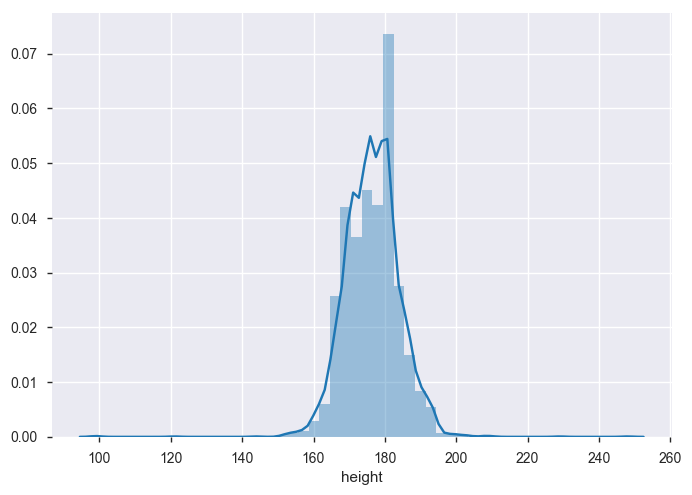

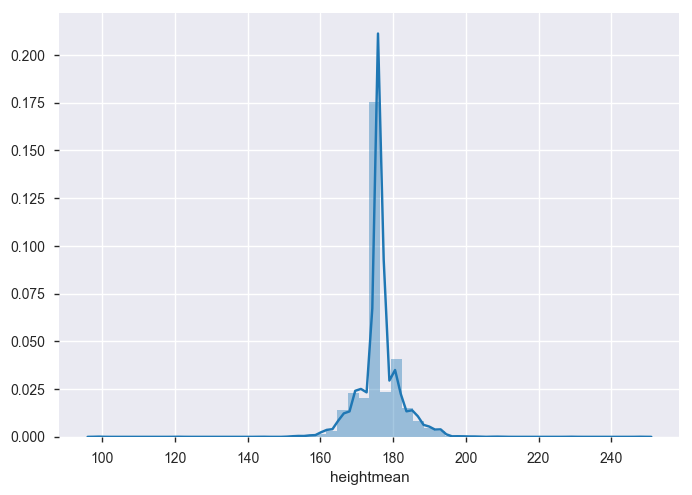

In [12]:
# First let's round to the nearest cm should be fine and reduce dimensionality
profiles.loc[pd.notnull(profiles.height), 'height'] = profiles[pd.notnull(profiles.height)].height.astype(int)
sns.distplot(profiles.height.dropna());
plt.show()

profiles['heightmean'] = profiles.height
profiles.loc[pd.isnull(profiles.height), 'heightmean'] = int(profiles.height.mean())
sns.distplot(profiles.heightmean);

Number of records that have no height but do have age: 2934


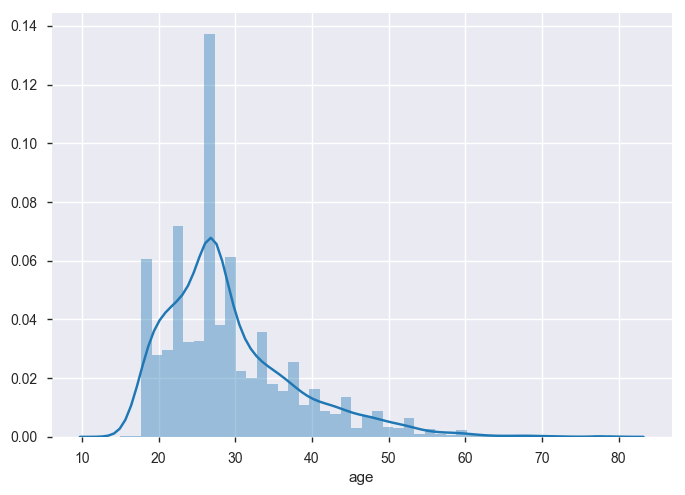

Number of records that have no height but do have weight: 110


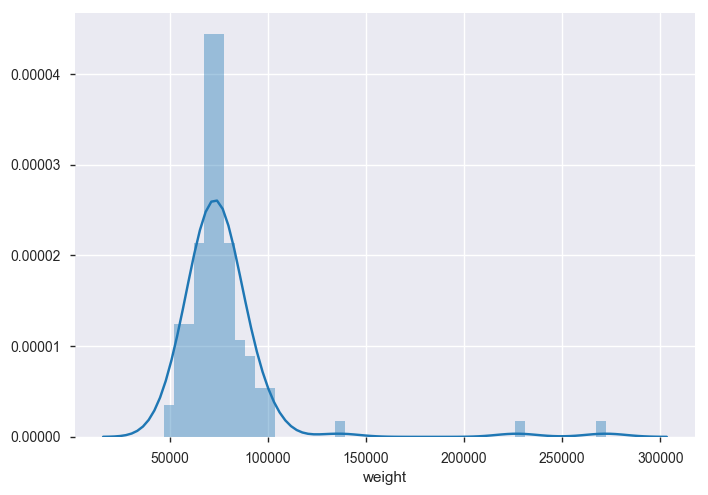

In [13]:
print("Number of records that have no height but do have age: {}"
      .format(len(profiles[pd.isnull(profiles.height) & pd.notnull(profiles.age)])))
sns.distplot(profiles[pd.isnull(profiles.height)].age);
plt.show()

print("Number of records that have no height but do have weight: {}"
      .format(len(profiles[pd.isnull(profiles.height) & pd.notnull(profiles.weight)])))
sns.distplot(profiles[pd.isnull(profiles.height)].weight.dropna());

In [14]:
from sklearn.linear_model import LinearRegression
cols = ['height', 'weight', 'age']
wdf = profiles[cols].dropna()
X = wdf.iloc[:, 1:]
y = wdf.iloc[:, 0].to_frame()

lr = LinearRegression()
lr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Number of records that do not have a value for height: 2934
Number of records that do not have a value for height: 2824


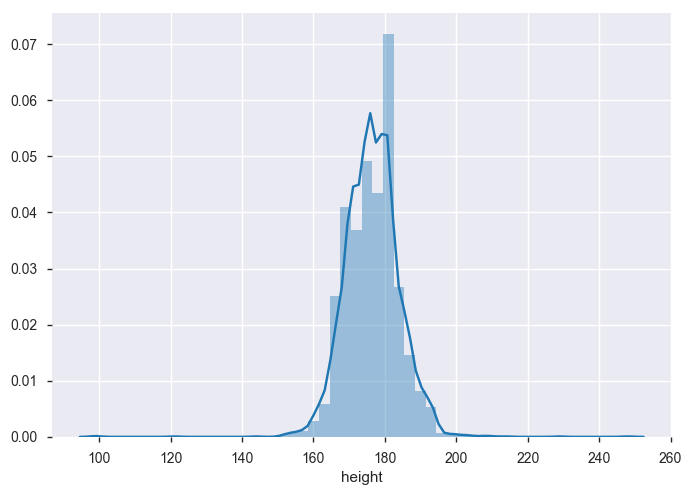

In [15]:
idx = pd.isnull(profiles.height) & pd.notnull(profiles.weight) & pd.notnull(profiles.age)
print("Number of records that do not have a value for height: {}".format(len(profiles[pd.isnull(profiles.height)])))
profiles.loc[idx, 'height'] = lr.predict(profiles[cols][idx].values[:, 1::]).astype(int)
print("Number of records that do not have a value for height: {}".format(len(profiles[pd.isnull(profiles.height)])))
sns.distplot(profiles.height.dropna());

Number of records that do not have a value for height: 0


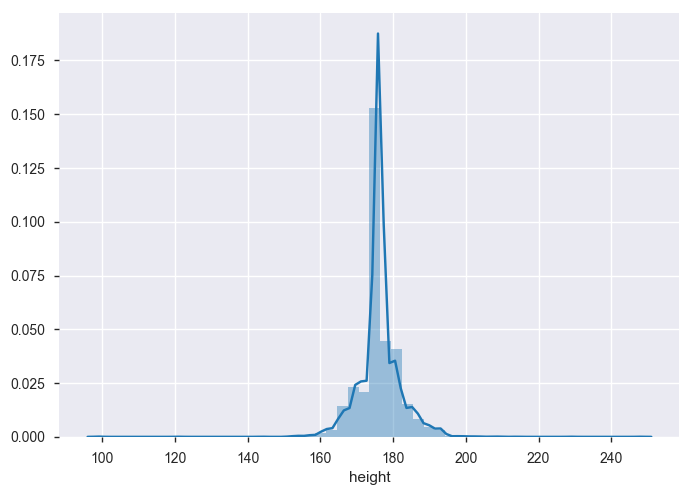

In [16]:
cols = ['height', 'age']
wdf = profiles[cols].dropna()
X = wdf.iloc[:, 1].to_frame()
y = wdf.iloc[:, 0].to_frame()

lr = LinearRegression()
lr.fit(X, y)

idx = pd.isnull(profiles.height) & pd.notnull(profiles.age)
profiles.loc[idx, 'height'] = lr.predict(profiles[cols][idx].values[:, 1::]).astype(int)
print("Number of records that do not have a value for height: {}".format(len(profiles[pd.isnull(profiles.height)])))
sns.distplot(profiles.height);

### Photo counts + extract first photo url
As-is, the photo fields are not terribly helpful. We could build a massive deep learning network and actually use the profile pictures to predict whether or not each user would swipe based on the photo, but the amount of resources required to build a network of that size/complexity would not likely be worth the effort.

However, we can attempt to get something useful out of it - a simple count of how many photos each user posts may provide some signal. For example, some users may only swipe users that have several pictures to look at, while others may only look at the first photo before making up their minds.

Additionally, when we generate the recommendations later, we'll want to have a photo so we'll extract the first photo (if it exists) out of the public_photo_count field

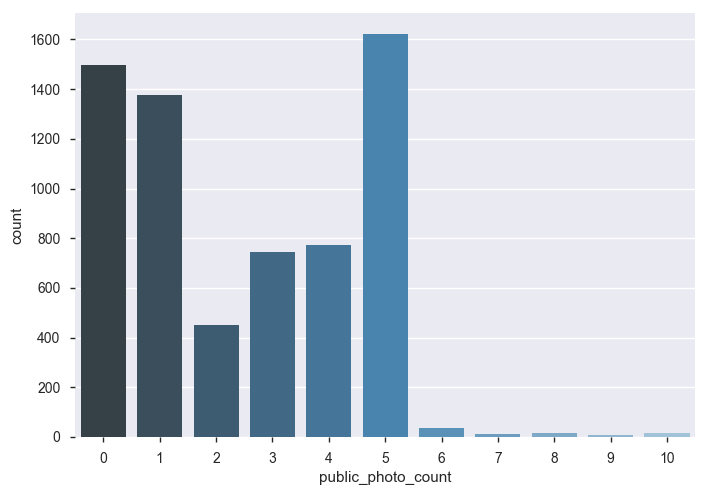

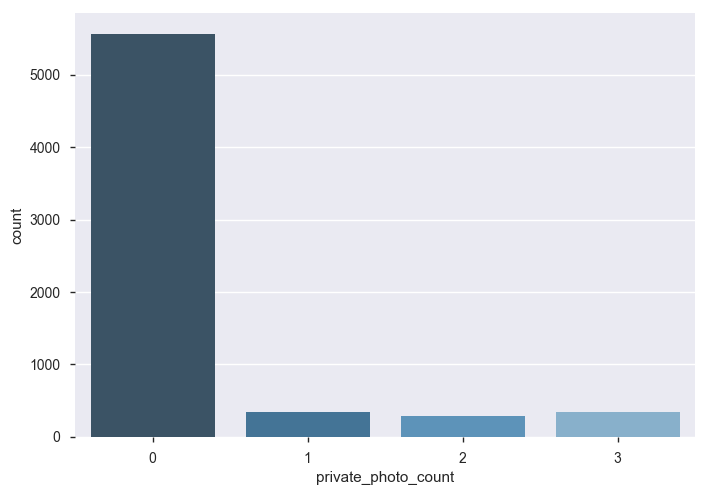

In [17]:
def extract_photo(x):
    SEARCH = '"medium": "'
    
    if pd.isnull(x) or not SEARCH in x:
        return ''

    idxs = x.find(SEARCH) + len(SEARCH)
    idxe = x.find('"', idxs)
    return x[idxs:idxe]

# The json string that stores the photos uses the "id" field for each photo. Count that and we'll have the photo count
profiles['public_photo_count'] = profiles.public_photos.map(lambda x: 0 if pd.isnull(x) else x.count('"id":'))
profiles['private_photo_count'] = profiles.private_photos.map(lambda x: 0 if pd.isnull(x) else x.count('"id":'))

# Gind the URL for the medium sized photo
profiles['photo'] = profiles.public_photos.map(extract_photo)

# del profiles['public_photos']
# del profiles['private_photos']

# Take a look at the distribution of photo counts
sns.countplot(x="public_photo_count", data=profiles, palette="Blues_d");
plt.show()
sns.countplot(x="private_photo_count", data=profiles, palette="Blues_d");

### Instagram photos
Again, here we can at least count...

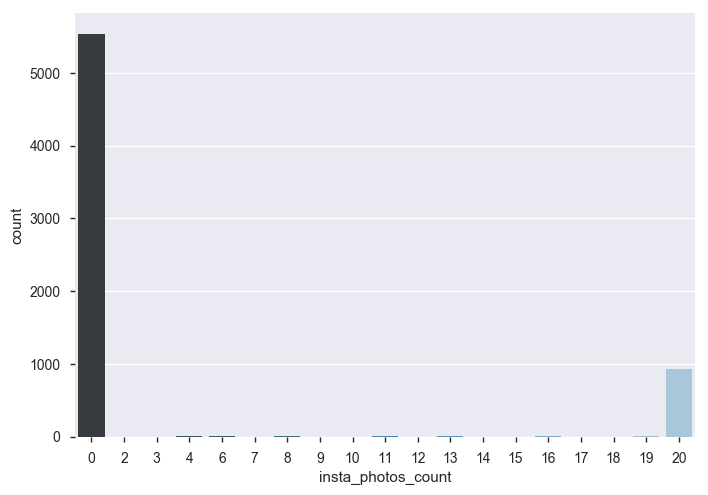

In [18]:
profiles['insta_photos_count'] = profiles.instagram_photos.map(lambda x: str(x).count('"large":'))
sns.countplot(x="insta_photos_count", data=profiles, palette="Blues_d");

Almost all users are 0 or 20. About 1/6th of users have any photos at all, so let's use that as a boolean flag

In [19]:
profiles.loc[profiles.insta_photos_count > 0, 'has_insta_photo'] = 1

### Photo Verification Status
Seems to be a transitory value used for filtering, but it's reasonably populated in ~25% of users, so we'll take it

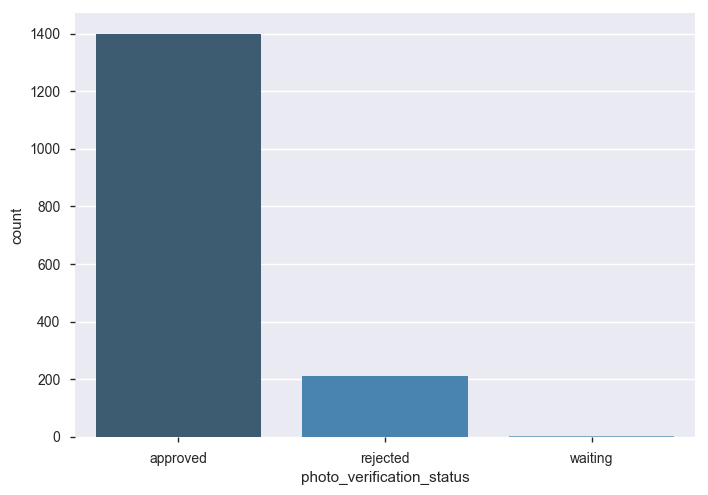

In [20]:
# One-hot encode the 4 potential values: {approved, waiting, rejected, unknown}
sns.countplot(x="photo_verification_status", data=profiles, palette="Blues_d");
profiles = pd.concat([profiles, pd.get_dummies(profiles.photo_verification_status)], axis=1)

### Relationship Status
This is a categorical variable (there are only a set number of possible values) and it needs to be converted to a format that can be incorporated into the collaborative filter

In [21]:
# Sometimes instead of NaN the value is the string "null". Clean that up
profiles.loc[profiles.relationship_status == 'null', 'relationship_status'] = np.NaN

# Call "get_dummies" to perform one-hot encoding (each possible value gets a boolean column) and merge the new columns
# back to the dataframe
profiles = pd.concat([profiles, pd.get_dummies(profiles.relationship_status)], axis=1)

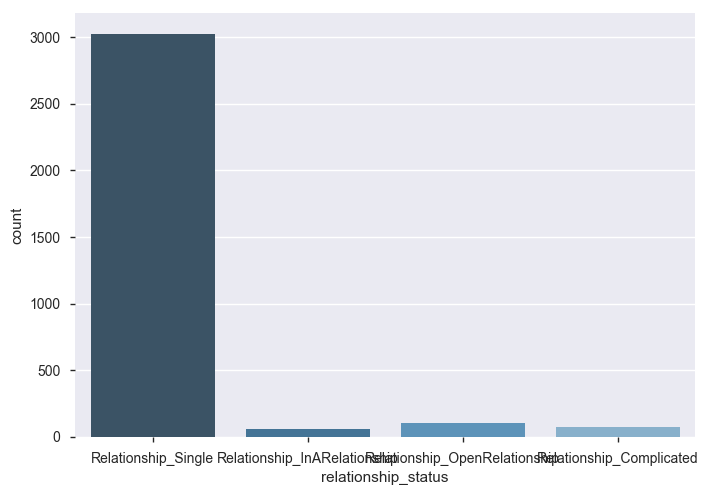

In [22]:
sns.countplot(x="relationship_status", data=profiles, palette="Blues_d");

Notice, virtually no one is anything other than "Single". There are also quite a few null values - so perhaps it doesn't default to Single? We could probably just drop all the other features other than the Single flag

In [23]:
del profiles['Relationship_InARelationship']
del profiles['Relationship_OpenRelationship']
del profiles['Relationship_Complicated']

### Looking For
Slightly different than the relationship status - looking_for can be set to any combination of the possible values. So the get_dummies() method for one-hot encoding won't work. We'll need to create a different column for each value manually

In [24]:
profiles['lf_chat'] = profiles.looking_for.map(lambda x: int('LookingFor_Chat' in str(x)))
profiles['lf_dates'] = profiles.looking_for.map(lambda x: int('LookingFor_Dates' in str(x)))
profiles['lf_friends'] = profiles.looking_for.map(lambda x: int('LookingFor_Friends' in str(x)))
profiles['lf_networking'] = profiles.looking_for.map(lambda x: int('LookingFor_Networking' in str(x)))
profiles['lf_relationships'] = profiles.looking_for.map(lambda x: int('LookingFor_Relationships' in str(x)))
profiles['lf_hookup'] = profiles.looking_for.map(lambda x: int('LookingFor_Hookup' in str(x)))

Let's take a look at how they're distributed...

In [25]:
pp.ProfileReport(profiles[['lf_chat', 'lf_dates', 'lf_friends', 'lf_networking', 'lf_relationships', 'lf_hookup']])

Number of variables,6
Number of observations,6550
Total Missing (%),0.0%
Total size in memory,307.1 KiB
Average record size in memory,48.0 B
Numeric,6
Categorical,0
Date,0
Text (Unique),0
Rejected,0
Distinct count,2


Dates and Friends are the most common things users are looking for, and Networking is the least, but all the different values are sufficiently represented to potentially be useful

### Favorite position - one-hot encoding, likely an extremely important indicator

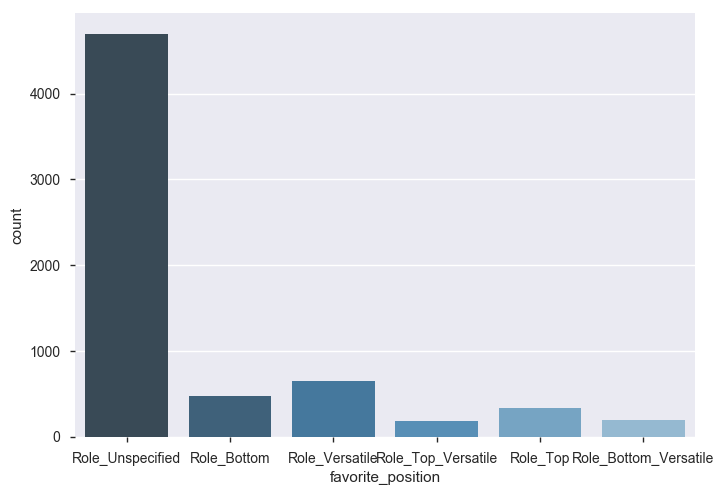

In [26]:
profiles.loc[pd.isnull(profiles.favorite_position), 'favorite_position'] = 'Role_Unspecified'
sns.countplot(x="favorite_position", data=profiles, palette="Blues_d");
plt.show()
profiles = pd.concat([profiles, pd.get_dummies(profiles.favorite_position)], axis=1)

Perhaps not - looks like >70% of users did not set their preference

### About
Any open-ended text is an obvious candidate for text analytics, but in a multi-language app this is particularly
difficult. You essentially would need a different model for each language (which is also complicated by the fact that
a user may have a profile in a different language than that specified by the device/locale settings.

A few metrics that could be useful without a complex text analysis project:

1. Profile length (in words) - some people may only want good pictures and not even read the profile. Others may skip anyone who isn't funny/interesting/etc. Having a lot/little to say could be useful
2. Profile length (in characters) - the total number of characters in the profile
3. Average word length - characters per word, an approximation of vocabulary
4. Emojii count - there are a lot of emojiis present, some people love or hate these. It's probably not common enough of a determining factor to be very relevant, but it would be interesting to look into it.

For now, we'll just look into the profile length...

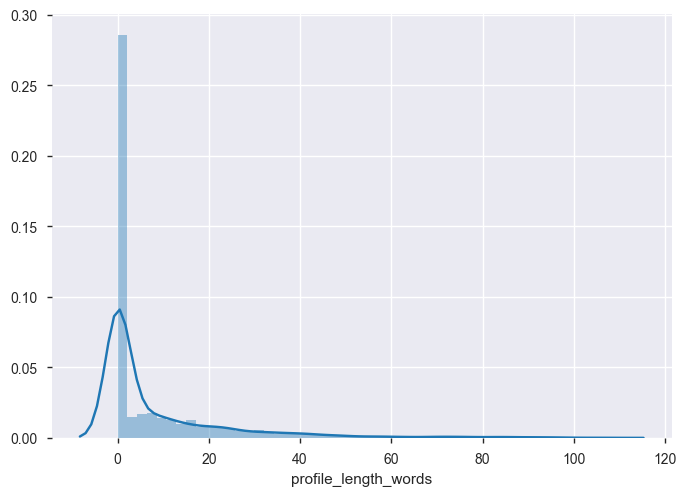

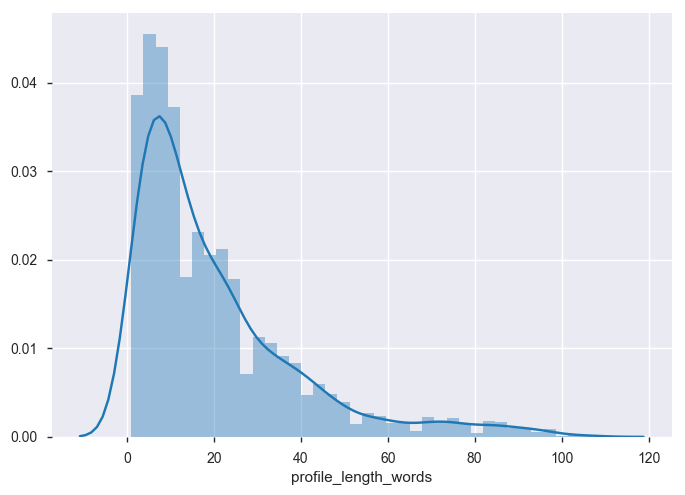

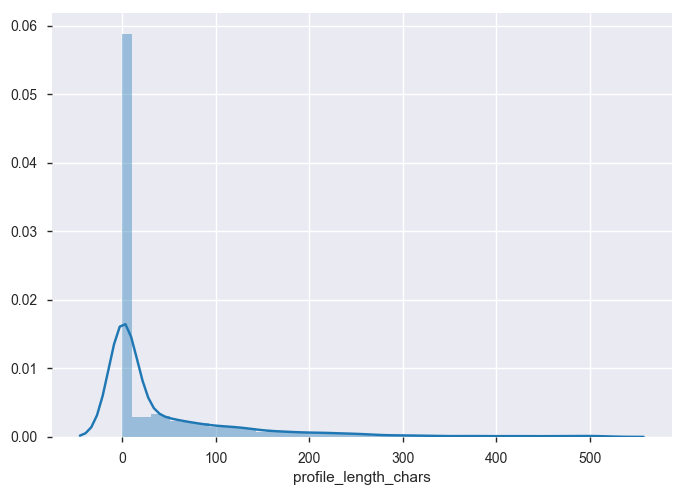

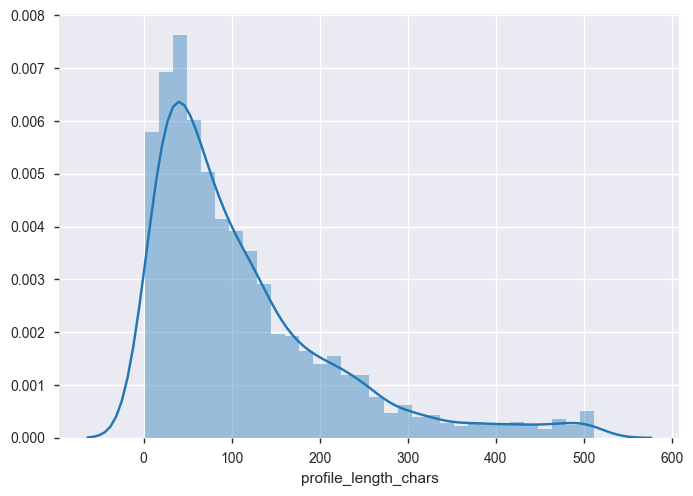

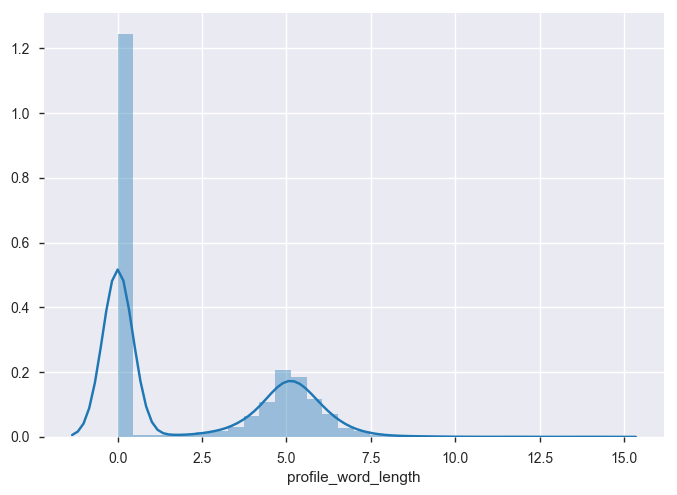

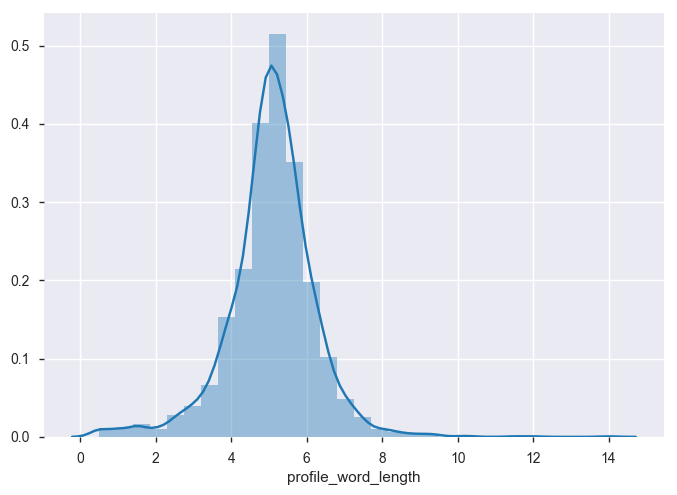

In [27]:
# Clear out the 'nan' values and then split the result to approximate the number of "words" in the profile
profiles['profile_length_words'] = profiles.about.map(lambda x: len(str(x).replace('nan', '').split()))
sns.distplot(profiles.profile_length_words);
plt.show()

# Let's take a look without the empty profiles since that makes up such a large percentage
notempty = profiles.profile_length_words > 0
sns.distplot(profiles[notempty].profile_length_words);
plt.show()

profiles['profile_length_chars'] = profiles.about.fillna('').map(lambda x: int(len(str(x).replace('nan', ''))))
sns.distplot(profiles.profile_length_chars);
plt.show()
sns.distplot(profiles[notempty].profile_length_chars);
plt.show()

profiles['profile_word_length'] = \
    (profiles.profile_length_chars / (profiles.profile_length_words + 1))
sns.distplot(profiles.profile_word_length, bins=30);
plt.show()
sns.distplot(profiles[notempty].profile_word_length, bins=30);

### Cloud Vision
Not sure what this is - an attractiveness rating of some sort? Could be very useful. Unfortunately the overwhelming
majority of values are set to 2.5 which I'm assuming is a default value. The other related fields may convey some slight amount of information but we'll ignore them for our first pass.

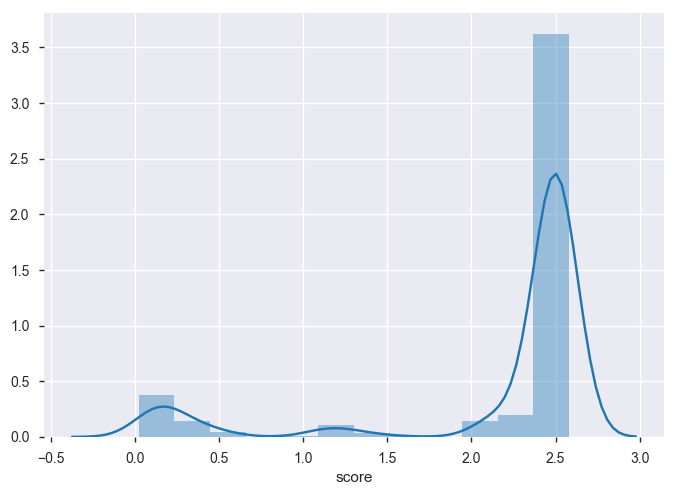

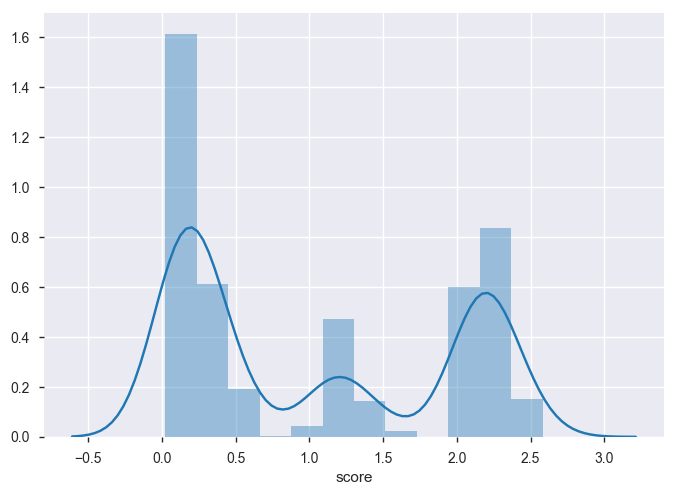

In [28]:
sns.distplot(profiles.score, bins=12);
plt.show()
sns.distplot(profiles[profiles.score != 2.5].score, bins=12);

### Interests
Again, text mining in a multi-language application is definitely a lot of work. It may be reasonable to do some basic text mining to find the most common interests and add them as binary features ("sports", "movies", "dancing", etc) but it's a lot of work with little clear payoff so we'll ignore it for our first-pass model. This could abolutely be a future area of investigation

In [29]:
del profiles['interests']

### Spotify
Individual songs don't provide enough signal, but genre info is present in the "favorite artists" field which may be useful for approximating that there is a common musical taste. Unfortunately only 3% of users have listed their favorite artists, so this won't be enough to do anything with for now

In [30]:
# Count the users with favorite_artists field length greater than 0
len(profiles[pd.notnull(profiles.favorite_artists) & (profiles.favorite_artists.map(lambda x: len(str(x)) > 0))])

198

## Look at the relationships between some of the prepared features
We're going to do a lot of plotting here, visual inspection of feature distributions and relationships can help to identify what to keep and what to throw out.

### Age/Weight/Height

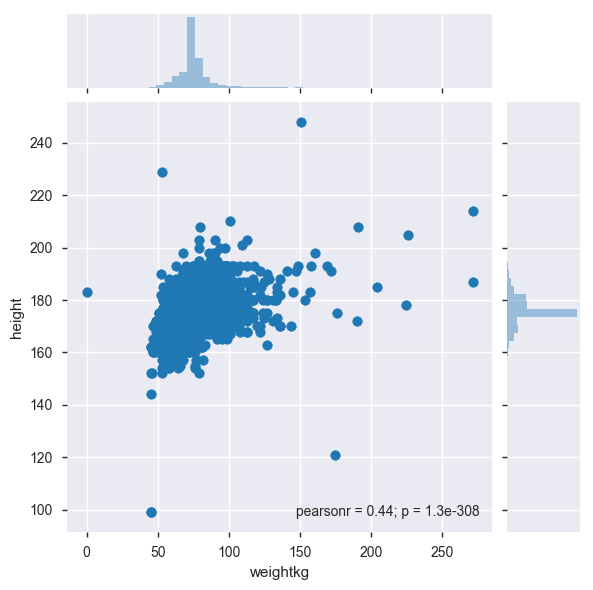

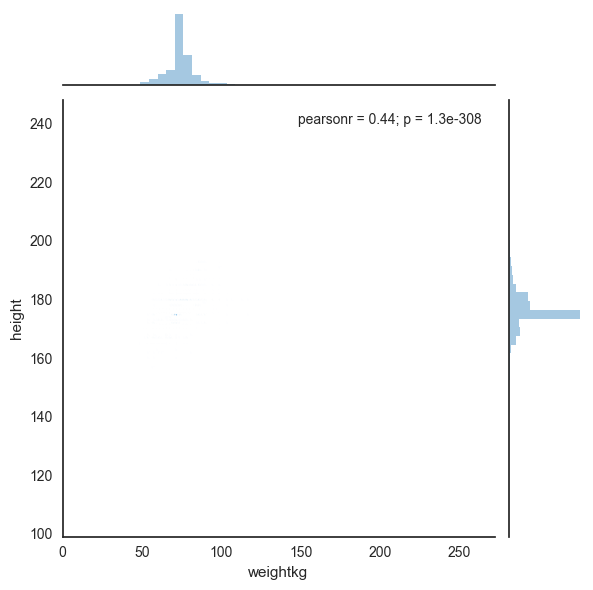

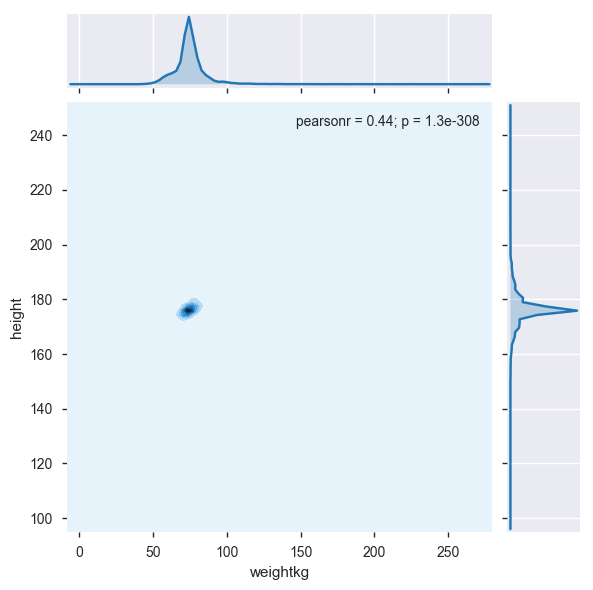

In [31]:
sns.jointplot(x='weightkg', y='height', data=profiles);
plt.show()

with sns.axes_style("white"):
    sns.jointplot(x='weightkg', y='height', data=profiles, kind="hex");
plt.show()

sns.jointplot(x="weightkg", y="height", data=profiles, kind="kde");

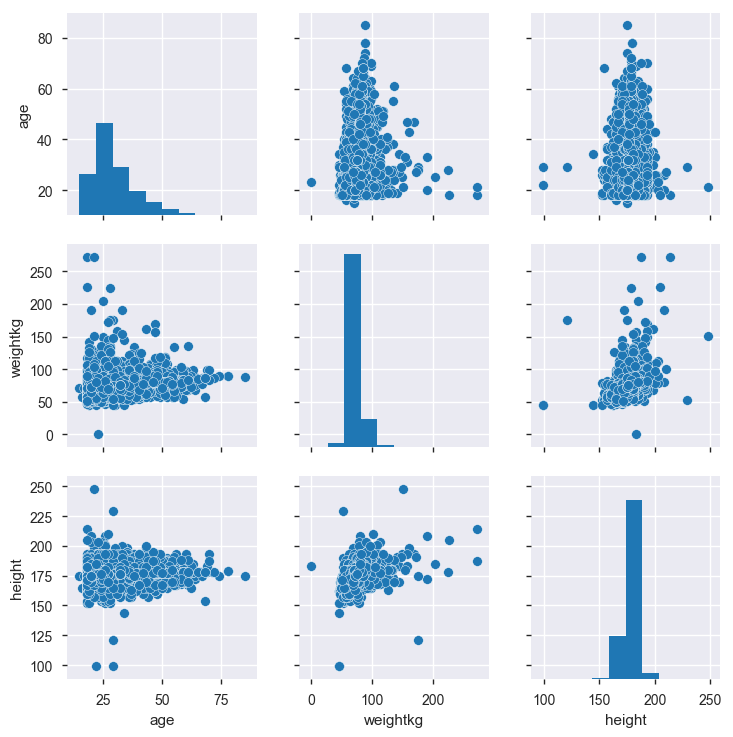

In [32]:
sns.pairplot(profiles[['age', 'weightkg', 'height']]);

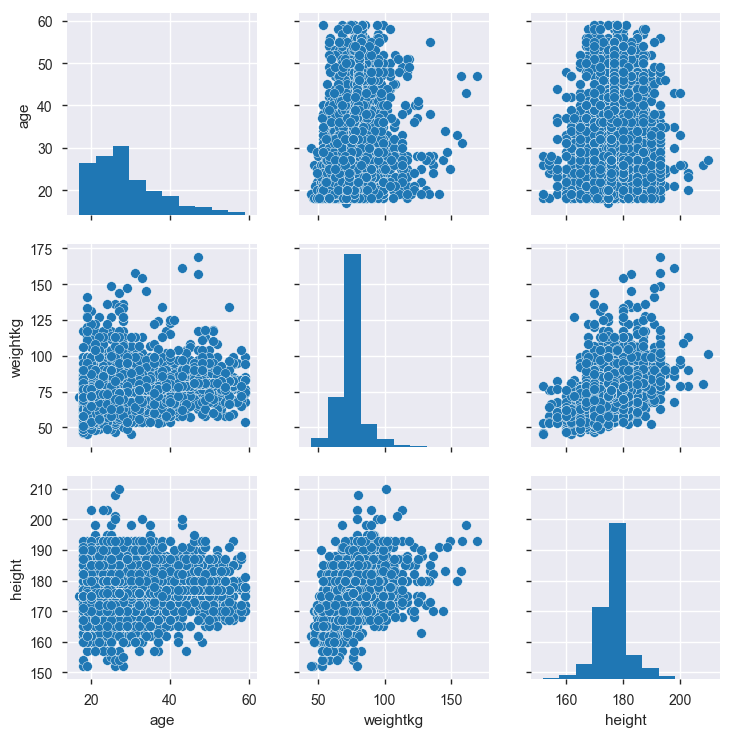

In [33]:
# Let's remove some of the outliers and see if that helps...
hrange = (profiles.height > 150) & (profiles.height < 220)
wrange = (profiles.weightkg > 40) & (profiles.weightkg < 170)
arange = (profiles.age > 16) & (profiles.age < 60)
sns.pairplot(profiles[hrange & wrange & arange][['age', 'weightkg', 'height']].dropna());

## Remove original variables
Many of the features we engineered were derived from raw features. If those features aren't possible to use on their
own, then we'll need to clean those up

In [38]:
print(profiles.columns.values)
del profiles['weight']
del profiles['insta_photos_count']
del profiles['instagram_photos']
del profiles['photo_verification_status']
del profiles['favorite_position']
del profiles['about']
del profiles['pending']
del profiles['score_date']
del profiles['spotify_username']
del profiles['favorite_artists']
del profiles['spotify_refresh_token']

['account_id' 'seen' 'birthday' 'public_photos' 'private_photos' 'height'
 'relationship_status' 'looking_for' 'about' 'review' 'pending' 'score'
 'score_date' 'favorite_position' 'instagram_photos'
 'photo_verification_status' 'photo_verification_data' 'favorite_song'
 'spotify_username' 'favorite_artists' 'spotify_refresh_token'
 'email_verification_status' 'age' 'weightkg' 'weightkgmean' 'heightmean'
 'public_photo_count' 'private_photo_count' 'photo' 'has_insta_photo'
 'approved' 'rejected' 'waiting' 'Relationship_Single' 'lf_chat' 'lf_dates'
 'lf_friends' 'lf_networking' 'lf_relationships' 'lf_hookup' 'Role_Bottom'
 'Role_Bottom_Versatile' 'Role_Top' 'Role_Top_Versatile' 'Role_Unspecified'
 'Role_Versatile' 'profile_length_words' 'profile_length_chars'
 'profile_word_length']


## Normalize the features

## Examine our final feature set

In [39]:
pp.ProfileReport(profiles)

Number of variables,40
Number of observations,6550
Total Missing (%),13.7%
Total size in memory,1.6 MiB
Average record size in memory,250.0 B
Numeric,26
Categorical,9
Date,1
Text (Unique),1
Rejected,3
Distinct count,2


In [ ]:
profiles.to_csv(path + 'surgeapp_profiles.csv', index=False)